# <center>Меры качества кластеризации. Практика
Мы будем использовать данные, взятые с датчиков акселерометров и гироскопов смартфонов Samsung Galaxy S3. Телефоны носили в кармане добровольцы в возрасте от 19 до 49 лет. Смартфоны постоянно фиксировали значения ускорения и скорости по трём измерениям, а поведение людей записывали на видео, чтобы вручную отметить, какую физическую активность осуществлял человек в тот или иной момент.

Данные содержат следующие признаки:
* различные показатели с акселерометра и гироскопа;
* метка активности (физическая активность человека в конкретный момент).

Попробуем на основе данных с гироскопа и акселерометра разделить активности людей на некоторые схожие по своим характеристикам группы. В идеале наблюдения во время ходьбы должны попасть в один кластер, наблюдения во время подъёма по лестнице — в другой и т. д.



In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import *
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

pio.templates.default = 'plotly_dark'
pio.renderers.default = 'png'

**Задание 4.1**  
Так как изначально данные были представлены для решения задачи классификации, то они находятся в разных файлах (обучающая и тестовая выборки в соотношении 70/30). Соедините признаки так, чтобы сначала шла обучающая выборка, а затем — тестовая, и отдельно соедините значения целевых переменных (разумеется, в том же порядке).

In [2]:
X = pd.concat([
    pd.DataFrame(np.loadtxt('data/train.txt')),
    pd.DataFrame(np.loadtxt('data/test.txt'))
], axis=0)
y = pd.concat([
    pd.Series(np.loadtxt('data/train_labels.txt')),
    pd.Series(np.loadtxt('data/test_labels.txt'))
], axis=0)
print(
    'Количество объектов X:', X.shape[0],
    '\nКоличество признаков X:', X.shape[1],
    '\nКоличество объектов y:', y.shape[0]
)

Количество объектов X: 10299 
Количество признаков X: 561 
Количество объектов y: 10299


**Задание 4.2**  
Теперь найдите число различных активностей, то есть на сколько кластеров в идеале должны разделиться наблюдения.

In [3]:
print('Количество уникальных известных кластеров:', y.nunique())

Количество уникальных известных кластеров: 6


Как видите, есть ряд активностей, обозначенных цифрами. Эти метки означают следующее:

* 1 — ходьба;
* 2 — подъём;
* 3 — спуск;
* 4 — сидение;
* 5 — стояние;
* 6 — лежание.


**Задание 4.3**  
Далее необходимо отмасштабировать признаки. Будем использовать для этого алгоритм `StandardScaler`.

In [4]:
X_s = StandardScaler().fit_transform(X)

**Задание 4.4**  
Пора переходить к кластеризации. Для начала определите оптимальное количество кластеров, используя внутренние меры кластеризации. Используйте все известные вам коэффициенты, реализуемые в библиотеке `sklearn`: коэффициент силуэта, индекс Калински — Харабаса и индекс Дэвиса — Болдина. В качестве алгоритма возьмите `k-means++`, в качестве значения параметра `random_state` — число 42.

In [5]:
def get_optimal_clusters(X:pd.DataFrame):
    
    metrics_dict = {
        'n_clusters': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for n_clusters in range(2, 10):
        clusters_pred = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit_predict(X)
        metrics_dict['n_clusters'].append(n_clusters)
        metrics_dict['silhouette'].append(silhouette_score(X, clusters_pred))
        metrics_dict['calinski_harabasz'].append(calinski_harabasz_score(X, clusters_pred))
        metrics_dict['davies_bouldin'].append(davies_bouldin_score(X, clusters_pred))
    
    return pd.DataFrame(metrics_dict)

clustering_info = get_optimal_clusters(X_s)        

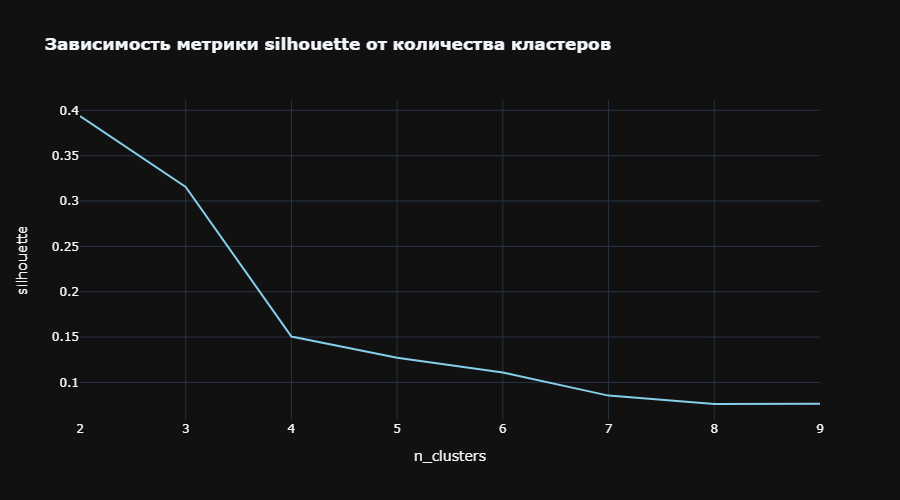

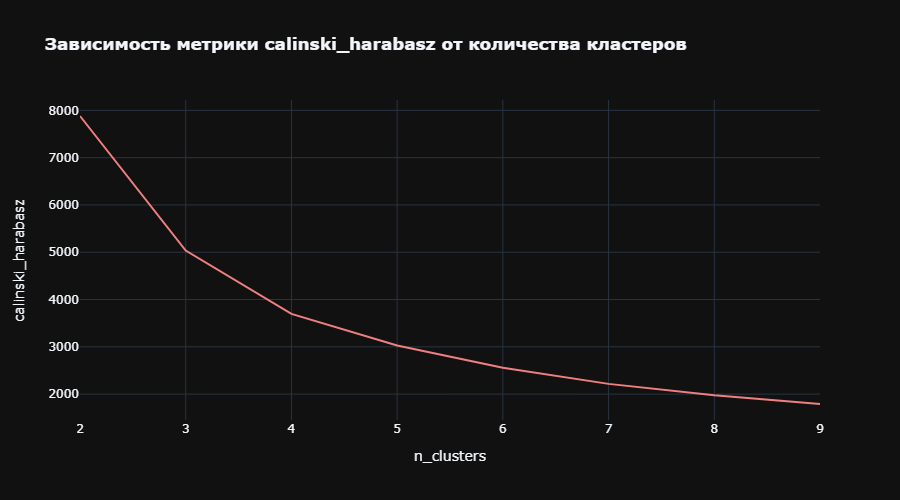

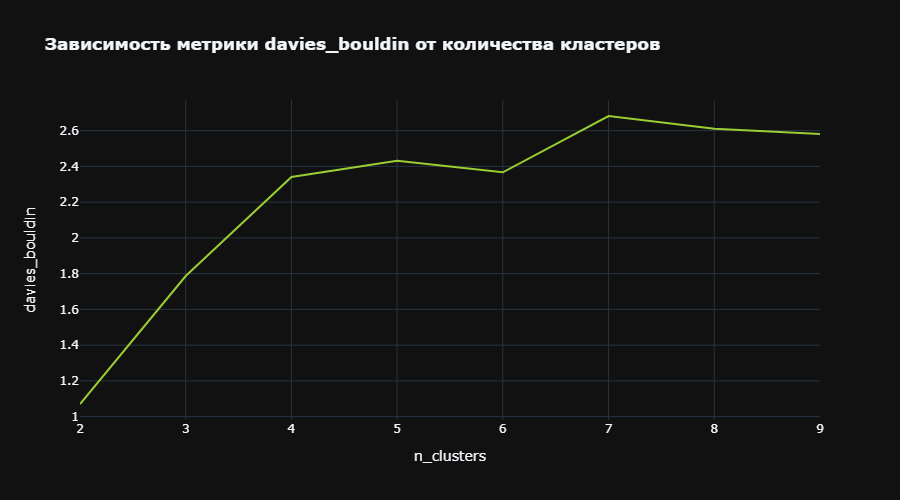

In [6]:
px.line(
    data_frame=clustering_info,
    x='n_clusters',
    y='silhouette',
    color_discrete_sequence=['SkyBlue'],
    width=900,
    height=500,
    title='<b>Зависимость метрики silhouette от количества кластеров</b>'
).show()
px.line(
    data_frame=clustering_info,
    x='n_clusters',
    y='calinski_harabasz',
    color_discrete_sequence=['LightCoral'],
    width=900,
    height=500,
    title='<b>Зависимость метрики calinski_harabasz от количества кластеров</b>'
).show()
px.line(
    data_frame=clustering_info,
    x='n_clusters',
    y='davies_bouldin',
    color_discrete_sequence=['YellowGreen'],
    width=900,
    height=500,
    title='<b>Зависимость метрики davies_bouldin от количества кластеров</b>'
).show()

**Задание 4.5**  
Теперь давайте оценим качество кластеризации с точки зрения внешних мер. Реализуйте кластеризацию с помощью классической версии алгоритма `k-means`. Пусть количество кластеров будет соответствовать количеству активностей. Задайте следующие значения параметров: `random_state=42, init='random'`.

In [7]:
y_pred = KMeans(random_state=42, init='random', n_clusters=6, n_init=10).fit_predict(X_s)
print(
    'Homogeneity:', homogeneity_score(y, y_pred).round(2),
    '\nCompleteness:', completeness_score(y, y_pred).round(2),
    '\nAdjusted Rand index:', round(adjusted_rand_score(y, y_pred), 2)
)

Homogeneity: 0.54 
Completeness: 0.58 
Adjusted Rand index: 0.42


**Задание 4.6**  
Выясните, к каким кластерам были преимущественно отнесены различные активности (т. е. в какой кластер попало большинство наблюдений с этой активностью). Нумерацию кластеров начинайте с 1.

In [8]:
crosstab = pd.crosstab(index=y, columns=y_pred)
crosstab.index = ['Ходьба', 'Подъем', 'Спуск', 'Сидение', 'Стояние', 'Лежание']
crosstab.columns = range(1, 7)
crosstab

,1,2,3,4,5,6
Ходьба,0,0,903,78,741,0
Подъем,0,0,1242,5,295,2
Спуск,0,0,321,196,889,0
Сидение,91,1238,1,0,0,447
Стояние,0,1346,0,0,0,560
Лежание,1556,54,5,0,0,329


**Задание 4.7**  
Теперь попробуйте реализовать алгоритм `k-means` для двух кластеров (для того числа активностей, которое является оптимальным с точки зрения внутренних мер) и снова посмотреть, как алгоритм разобьёт активности по кластерам. Как и в предыдущем задании, нумерацию кластеров начинайте с 1.

In [9]:
y_pred = KMeans(random_state=42, init='random', n_clusters=2, n_init=10).fit_predict(X_s)
crosstab = pd.crosstab(index=y, columns=y_pred)
crosstab.index = ['Ходьба', 'Подъем', 'Спуск', 'Сидение', 'Стояние', 'Лежание']
crosstab.columns = range(1, 3)
crosstab

,1,2
Ходьба,1722,0
Подъем,1536,8
Спуск,1406,0
Сидение,3,1774
Стояние,0,1906
Лежание,12,1932


Разбиение на два кластера, которое нам навязчиво предлагали внутренние меры, вполне разумно, так как отражает два принципиально разных класса активностей: **неподвижные** и **подвижные**.



**Задание 4.8**  
Вычислите значение полноты для разбиения на два кластера алгоритмом `k-means.`

In [10]:
print('Completeness for 2 clusters KMeans:', completeness_score(y, y_pred).round(2))

Completeness for 2 clusters KMeans: 0.98


**Задание 4.10**  
Давайте сравним полученный результат с агломеративной иерархической кластеризацией. Реализуйте её также для двух кластеров и вычислите значение полноты.

In [11]:
y_pred_agg = AgglomerativeClustering(n_clusters=2).fit_predict(X_s)
print('Completeness for 2 clusters AgglomerativeClustering:', completeness_score(y, y_pred_agg).round(2))

Completeness for 2 clusters AgglomerativeClustering: 1.0


In [12]:
crosstab = pd.crosstab(index=y, columns=y_pred_agg)
crosstab.index = ['Ходьба', 'Подъем', 'Спуск', 'Сидение', 'Стояние', 'Лежание']
crosstab.columns = range(1, 3)
crosstab

,1,2
Ходьба,1722,0
Подъем,1544,0
Спуск,1406,0
Сидение,0,1777
Стояние,0,1906
Лежание,0,1944


***
# <center>PCA
**Задание 5.1**  
Найдите матрицу ковариаций для векторов. В качестве ответа укажите сумму всех значений матрицы.

In [13]:
v1, v2 = np.array([3, 4, 1]), np.array([1, 6, 2])
np.sum(np.cov([v1, v2])).round(2)

14.33

**Задание 5.5**  
Дана матрица признаков.
Какое минимальное количество главных компонент надо выделить, чтобы сохранить информацию о как минимум 90 % разброса данных?

In [14]:
A = np.array([
    [8,7,2,9],
    [1,3,6,3],
    [7,2,0,3],
    [10,3,1,1],
    [8,1,3,4]
])
# делаем датафрейм, чтобы считать среднее и
# стандартное отклонение для каждого столбца отдельно
df = pd.DataFrame(A)
df_std = (df - df.mean()) / df.std()
A_decomposed = PCA(n_components=0.9).fit_transform(df_std)
A_decomposed

array([[-1.61145254,  1.76368007,  0.01320928],
       [ 2.08441051,  1.01724955, -0.24417084],
       [-0.29568142, -0.95946326, -0.05272576],
       [-0.50390826, -1.24373821, -0.50808763],
       [ 0.3266317 , -0.57772816,  0.79177495]])

***
# <center> Снижение размерности. Практика
Представьте, что вы работаете в международной гуманитарной организации, главная задача которой — борьба с бедностью и помощь людям из наименее развитых стран. Для выполнения своей миссии ваша организация периодически финансирует различные проекты, поддерживающие нуждающиеся регионы.

Вы собрали 100 миллионов долларов и должны принять решение, как распределить эти деньги — в какие страны их направить в первую очередь. Как выбрать, кто сильнее всего нуждается в финансовой поддержке?

Конечно, можно взять страны с самыми низкими доходами населения или с самой маленькой продолжительностью жизни. А может, лучше помочь странам, у которых самая высокая инфляция? По отдельным признакам выбирать достаточно сложно — нам хотелось бы выявить группы стран, в которых в целом ситуация вызывает опасения по совокупности значений всех признаков.

Для решения этой задачи мы как раз и используем наши навыки в снижении размерности и кластеризации данных: попробуем выделить кластеры стран, схожих по своим характеристикам, и среди них выявить кластер особо нуждающихся.

Данные содержат следующие признаки:

* country — название страны;
* child_mort — показатель смертности детей до 5 лет;
* exports — показатель экспорта на душу населения;
* health — показатель затрат на здравоохранение на душу населения;
* imports — показатель импорта на душу населения;
* Income — средний доход на душу населения;
* Inflation — годовой показатель инфляции;
* life_expec — средняя продолжительность жизни;
* total_fer — суммарный коэффициент рождаемости;
* gdpp — значение ВВП на душу населения.

In [15]:
data = pd.read_csv('data/Country-data.zip')
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Каково максимальное значение показателя средней продолжительности жизни среди представленных стран?

In [16]:
data['life_expec'].max()

82.8

Чтобы получить более качественные результаты, необходимо стандартизировать данные.

In [17]:
data_scaled = pd.DataFrame(StandardScaler().fit_transform(data.drop(columns='country')), columns=data.columns.drop('country'))
data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


Как вы помните, нет смысла использовать сильно связанные друг с другом признаки, так как их можно преобразовать в один и таким образом уменьшить общее количество признаков. Давайте выясним, есть ли в данных такие признаки.

Постройте матрицу корреляций для всех признаков. Найдите максимальный коэффициент корреляции.

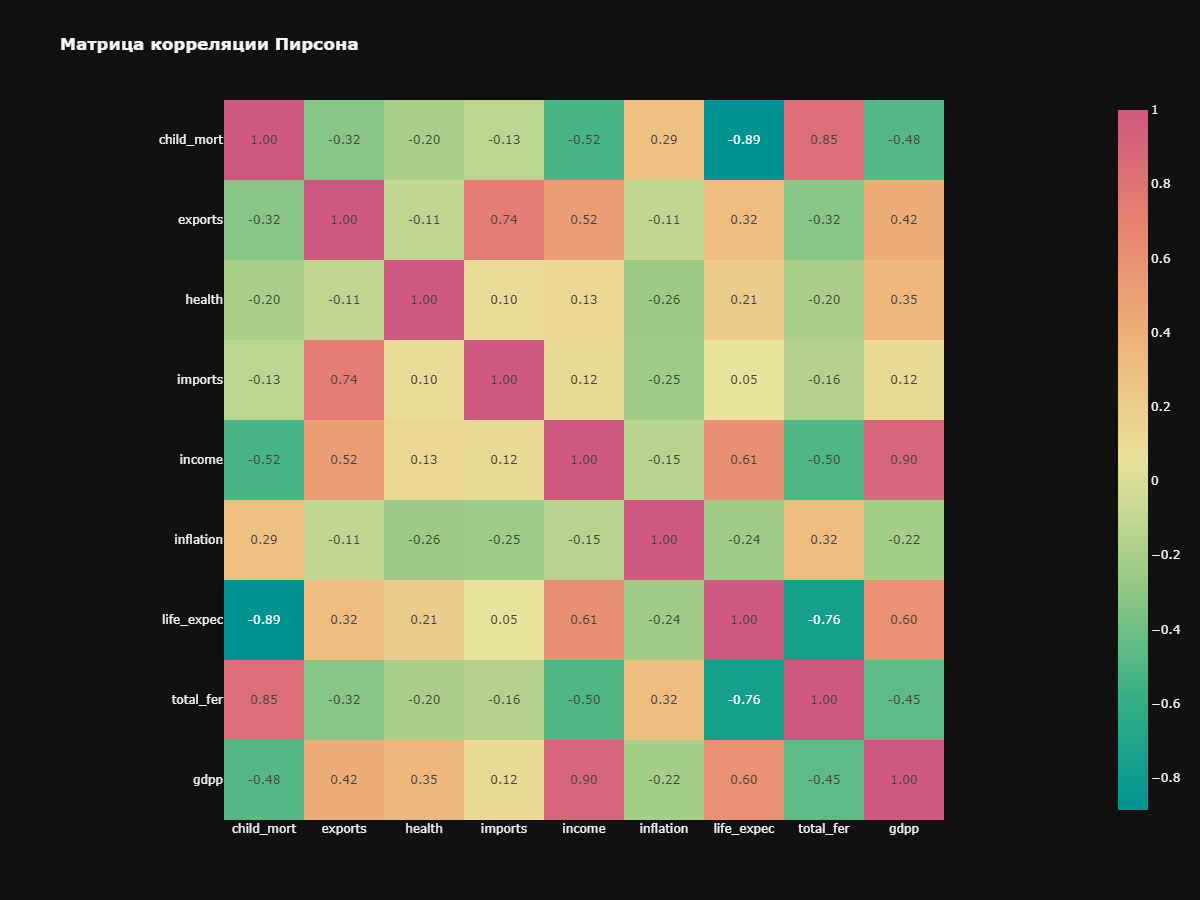

In [18]:
corr_matrix = data_scaled.corr()
px.imshow(
    corr_matrix,
    color_continuous_scale='temps',
    text_auto='.2f',
    title='<b>Матрица корреляции Пирсона</b>',
    width=1200,
    height=900
).show()

Теперь понизим размерность данных — возьмём для этого метод главных компонент (PCA) как самый простой и популярный.

Найдите минимальное число компонент, которые суммарно могут объяснить как минимум 90 % разброса данных.

In [19]:
pca = PCA(n_components=0.9, random_state=42)
pca_decomposed = pca.fit_transform(data_scaled)
pca_decomposed.shape

(167, 5)

Для того, чтобы объяснить бόльшую часть дисперсии, совершенно не требуется брать все признаки.

Какую долю дисперсии объясняет первая главная компонента?

In [20]:
pca.explained_variance_ratio_[0].round(2)

0.46

Как вы помните, при создании компонент с помощью PCA они должны получиться независимыми, то есть мы не должны теперь наблюдать высоких коэффициентов корреляции.

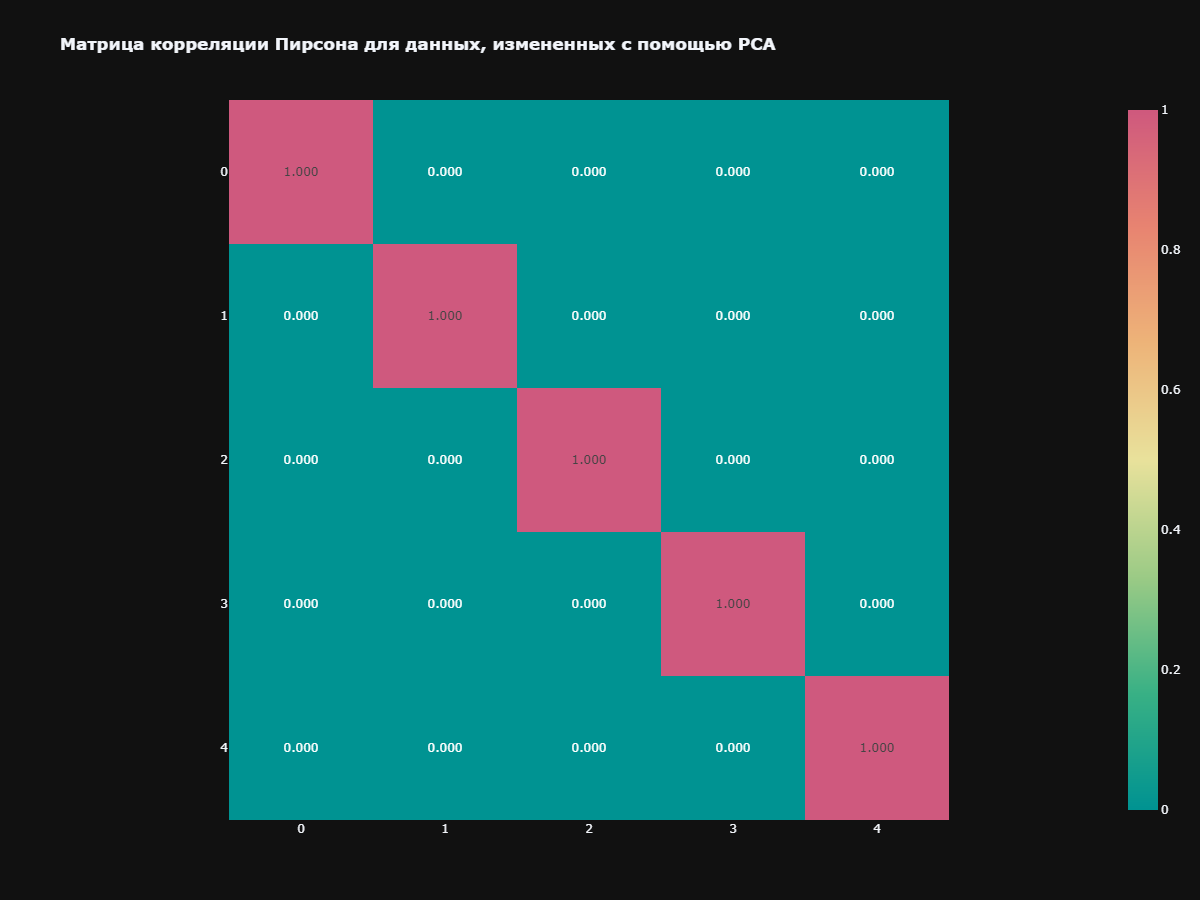

In [21]:
corr_matrix = pd.DataFrame(pca_decomposed).corr()
px.imshow(
    corr_matrix,
    color_continuous_scale='temps',
    text_auto='.3f',
    title='<b>Матрица корреляции Пирсона для данных, измененных с помощью PCA</b>',
    width=1200,
    height=900
).show()

Как видим, даже самый большой коэффициент корреляции практически неотличим от нуля — это значит, что мы всё сделали правильно, и теперь у нас есть пять независимых признаков, объясняющих до 90 % дисперсии.

Теперь, когда мы уменьшили размерность данных, можно переходить к кластеризации. Подберите оптимальное количество кластеров с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. Для кластеризации используйте алгоритм `k-means++`. В качестве значения параметра `random_state` возьмите число 1.

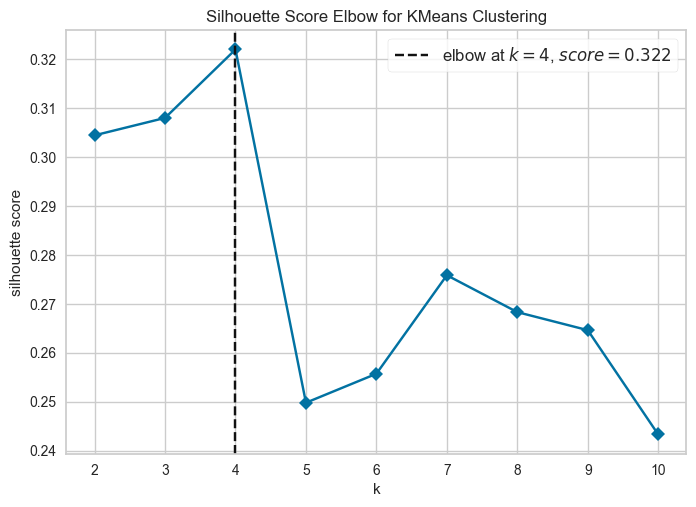

In [22]:
k_visualisation = KElbowVisualizer(
    estimator=KMeans(random_state=1, n_init=10),
    k=range(2, 11),
    metric='silhouette',
    timings=False
).fit(pca_decomposed).show()

Теперь, когда оптимальное количество кластеров выбрано, реализуйте алгоритм `k-means++` с этим параметром. В качестве значения `random_state` возьмите число 1.

В какой кластер попали страны, у которых самый высокий показатель детской смертности и самый низкий ВВП на душу населения?

In [23]:
k_means = KMeans(n_clusters=4, n_init=10, random_state=1).fit(pca_decomposed)
data['cluster'] = k_means.labels_
data.groupby(by='cluster')[['child_mort', 'gdpp']].agg([max, min]).sort_values(by=[('child_mort', 'max'), ('gdpp', 'min')], ascending=False)

child_mort          gdpp       
               max   min     max    min
cluster                                
1            208.0  36.9   17100    231
0             64.4   4.5   20700    592
3             13.8   2.6   87800  19800
2              6.8   2.8  105000  21100

Итак, мы понимаем, что именно в выбранном нами кластере находятся страны, которые особенно остро нуждаются в финансовой помощи. Однако на все страны у нас не хватит ресурсов, поэтому давайте выберем из выделенного кластера **три страны, в которых самая маленькая продолжительность жизни**.

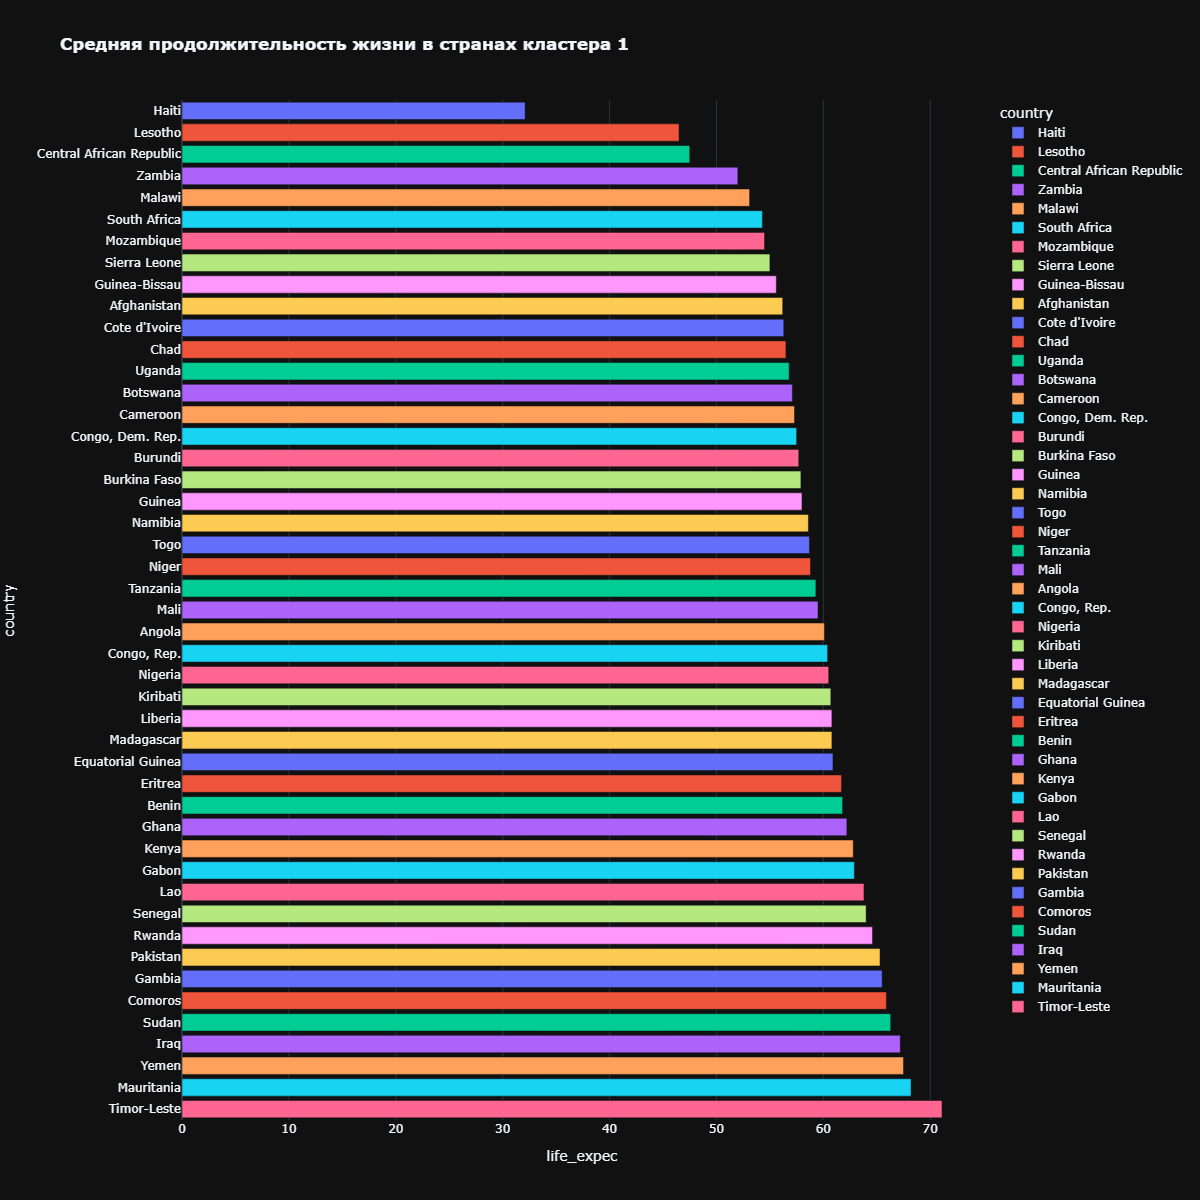

In [24]:
grouped = data[data['cluster'] == 1].groupby(by='country', as_index=False)['life_expec'].min().sort_values(by='life_expec')
px.bar(
    grouped,
    y='country',
    x='life_expec',
    color='country',
    width=1200,
    height=1200,
    title='<b>Средняя продолжительность жизни в странах кластера 1</b>'
).show()